# Frozen Lakes

#### Create the env with custom reward structure
This will provide P and R values to use in running the learners

In [2]:
import gym
import numpy as np
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from frozenlakes import MyMDPConverter
import gymnasium as gym
from pathlib import Path
from frozenlakes import Params
import numpy as np
import pandas as pd

params = Params(
    total_episodes=2000,
    learning_rate=0.01,
    gamma=0.9,
    epsilon=1,
    seed=26,
    is_slippery=True,
    n_runs=800000,
    action_size=None,
    state_size=None,
    proba_frozen=0.9,
    savefig_folder=Path("./_static/img/tutorials/"),
)
np.random.seed(params.seed)
rng = np.random.default_rng(params.seed)
map_sizes = [16]
res_all = pd.DataFrame()
st_all = pd.DataFrame()

# Create the figure folder if it doesn't exists
params.savefig_folder.mkdir(parents=True, exist_ok=True)

map_size=20
def setup_env():

    # Create the Frozen Lake environment
    env = gym.make(
        "FrozenLake-v1",
        is_slippery=params.is_slippery,
        render_mode="rgb_array",
        desc=generate_random_map(
            size=map_size, p=params.proba_frozen, seed=params.seed
        ),
    )

    env.action_space.seed(
        params.seed
    )
    env.reset()

    # Access the desc attribute
    lake_map = env.unwrapped.desc

    # Initialize and use the converter
    converter = MyMDPConverter(env)
    converter.convert_PR()

    # Function to convert 2D position to state index
    def pos_to_state(row, col, size):
        return row * size + col

    # Modify the R matrix for custom rewards
    for row in range(lake_map.shape[0]):
        for col in range(lake_map.shape[1]):
            state = pos_to_state(row, col, lake_map.shape[0])
            
            if lake_map[row, col] == b'H':
                converter.R[state, :] = -1  # Penalty for falling into a hole
            elif lake_map[row, col] == b'G':
                converter.R[state, :] = 1   # Reward for reaching the goal
            else:
                converter.R[state, :] = -0.01  # Step penalty for other states

    # Now you can use converter.P and converter.R with MDPToolbox algorithms
    P = converter.P
    R = converter.R

    return env, P, R



### VI

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(


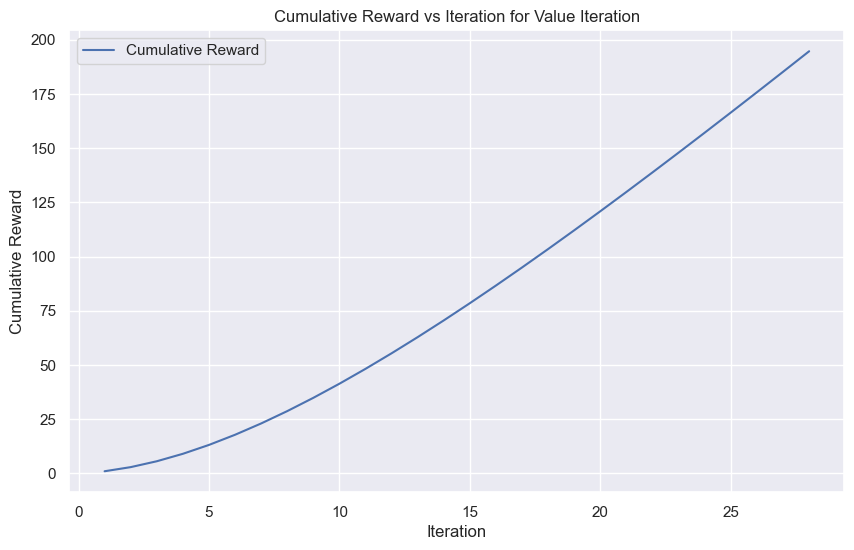

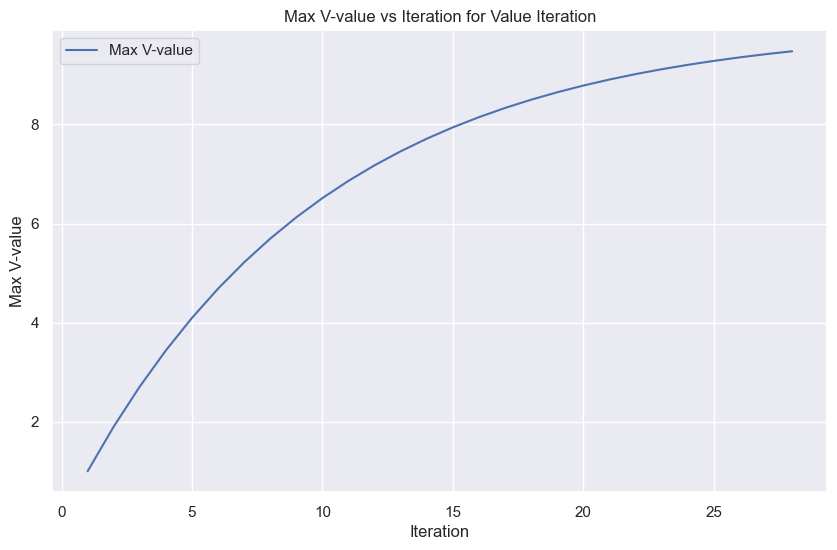

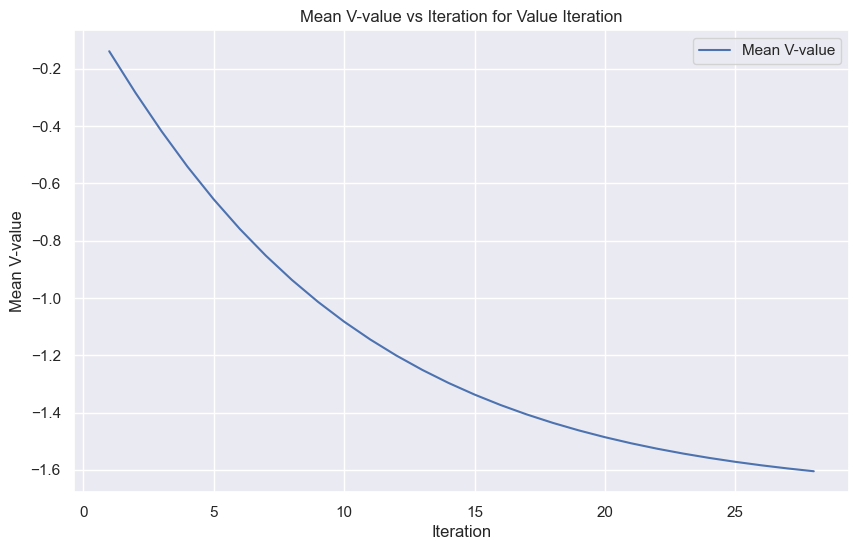

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.desc to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.desc` for environment variables or `env.get_wrapper_attr('desc')` that will search the reminding wrappers.
  logger.warn(


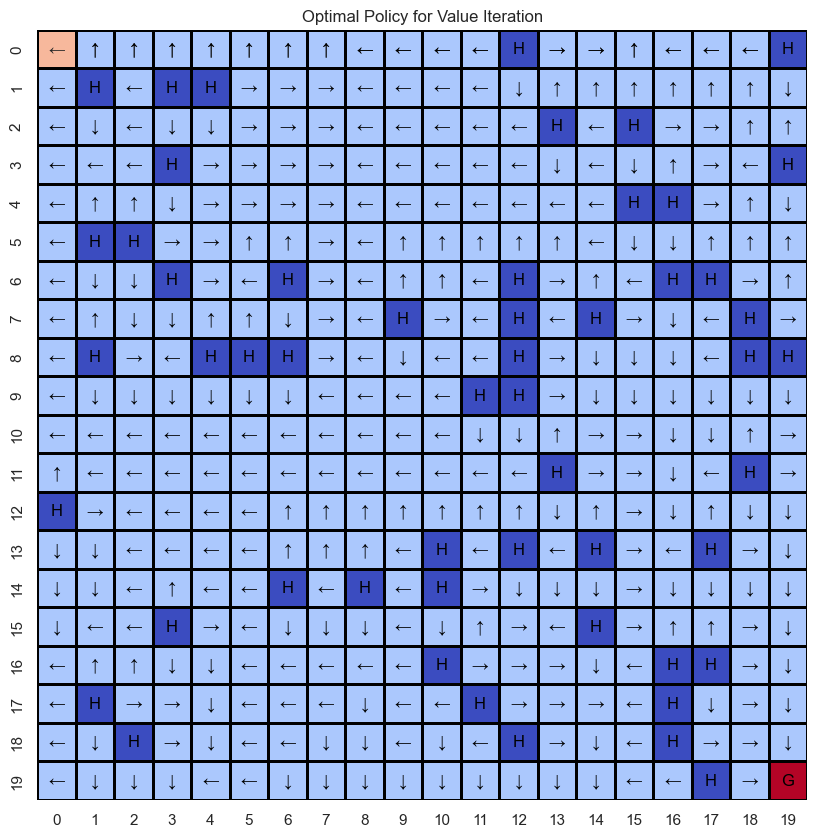

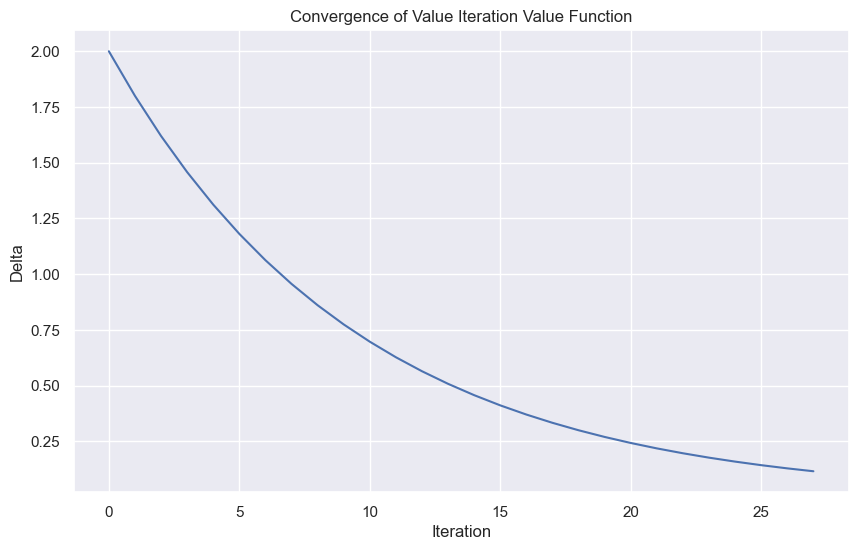

In [3]:
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from frozenlakes import MyMDPConverter, LearnerType
import numpy as np
from hiive.mdptoolbox.mdp import ValueIteration
from plots import find_terminal_states
from matplotlib import pyplot as plt
from newPlots import print_value_iteration_results, plot_optimal_policy_with_holes
import numpy as np
debug = False
learner_name = LearnerType.VALUE_ITERATION

env, P, R = setup_env()
V_learner = ValueIteration(P, R, params.gamma, epsilon=params.epsilon, max_iter=params.n_runs)

stats = V_learner.run()
# Initialize lists to collect stats
rewards_per_iteration = []
max_v_per_iteration = []
mean_v_per_iteration = []

# Extract stats for each iteration
for stat in V_learner.run_stats:
    rewards_per_iteration.append(stat['Reward'])
    max_v_per_iteration.append(stat['Max V'])
    mean_v_per_iteration.append(stat['Mean V'])

# Convert lists to a pandas DataFrame for easy plotting
vi_stats = pd.DataFrame({
    'Iteration': range(1, len(rewards_per_iteration) + 1),
    'Cumulative Reward': np.cumsum(rewards_per_iteration),
    'Max V': max_v_per_iteration,
    'Mean V': mean_v_per_iteration
})

# Plot Cumulative Reward vs Iteration
plt.figure(figsize=(10, 6))
plt.plot(vi_stats['Iteration'], vi_stats['Cumulative Reward'], label='Cumulative Reward')
plt.xlabel('Iteration')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward vs Iteration for Value Iteration')
plt.legend()
plt.show()

# Plot Max V vs Iteration
plt.figure(figsize=(10, 6))
plt.plot(vi_stats['Iteration'], vi_stats['Max V'], label='Max V-value')
plt.xlabel('Iteration')
plt.ylabel('Max V-value')
plt.title('Max V-value vs Iteration for Value Iteration')
plt.legend()
plt.show()

# Plot Mean V vs Iteration
plt.figure(figsize=(10, 6))
plt.plot(vi_stats['Iteration'], vi_stats['Mean V'], label='Mean V-value')
plt.xlabel('Iteration')
plt.ylabel('Mean V-value')
plt.title('Mean V-value vs Iteration for Value Iteration')
plt.legend()
plt.show()

print("stats\n", stats) if debug else None
# plot_policy(learner.policy, map_size)
term_states = find_terminal_states(env)

# Print the type of the policy to confirm what it is
print("Type of policy:", type(V_learner.policy)) if debug else None

# If the policy is a tuple, convert it to a NumPy array
if isinstance(V_learner.policy, tuple):
    policy_array = np.array(V_learner.policy)
else:
    policy_array = V_learner.policy  # If it's already an array, just use it as is

# Now print the policy array and its shape
print("Policy array:", policy_array) if debug else None
print("Shape of policy array:", policy_array.shape) if debug else None

# Verify the values in the policy:
print("Unique actions in policy:", np.unique(policy_array)) if debug else None

# Check if all states have a valid policy (no NaNs or unexpected values):
if np.all(np.isfinite(policy_array)) and set(np.unique(policy_array)).issubset({0, 1, 2, 3}):
    print("All states have a valid policy.") if debug else None
else:
    print("There are states with an invalid policy.") if debug else None
desc = env.unwrapped.desc
plot_optimal_policy_with_holes(V_learner.policy, desc, map_size, learner_name)

print_value_iteration_results(V_learner, map_size, learner_name)

env.close()

### PI

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(


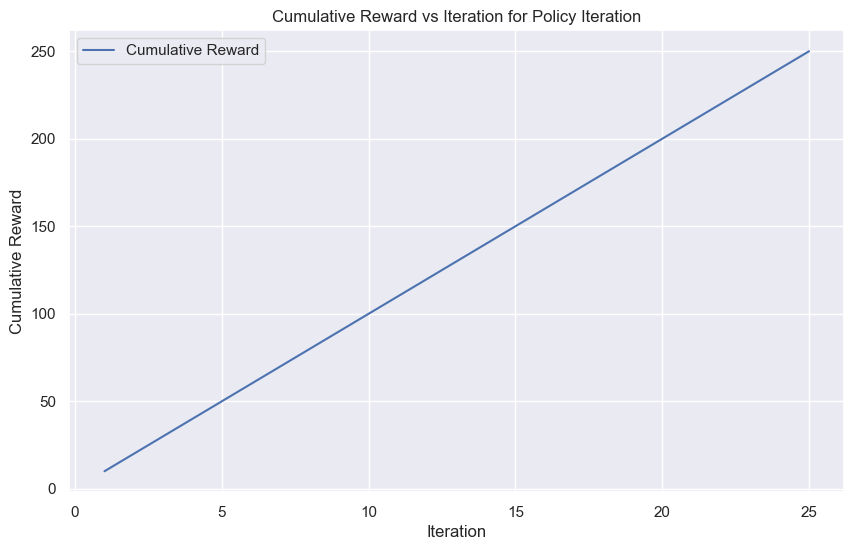

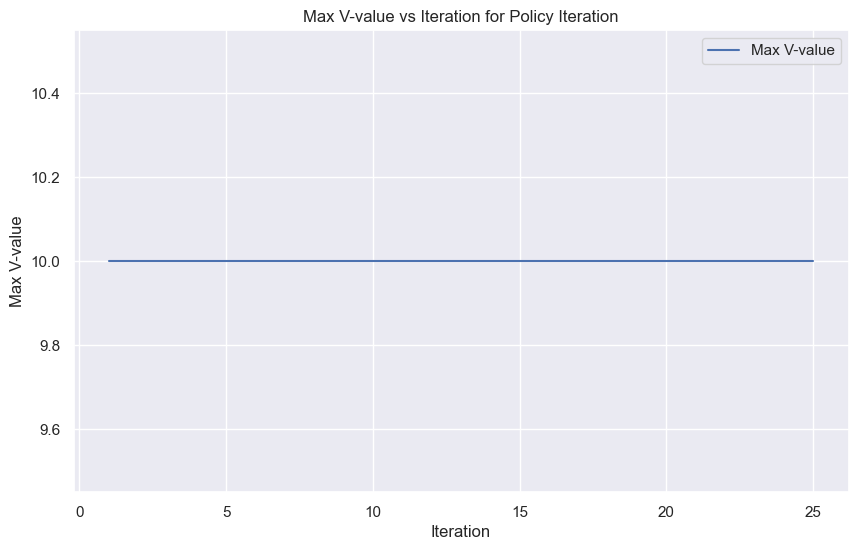

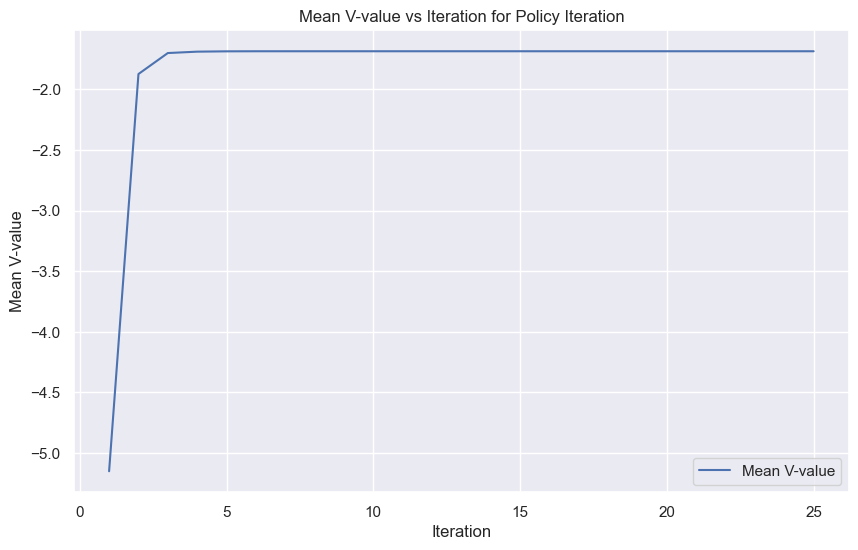

max v values 0     10.0
1     10.0
2     10.0
3     10.0
4     10.0
5     10.0
6     10.0
7     10.0
8     10.0
9     10.0
10    10.0
11    10.0
12    10.0
13    10.0
14    10.0
15    10.0
16    10.0
17    10.0
18    10.0
19    10.0
20    10.0
21    10.0
22    10.0
23    10.0
24    10.0
Name: Max V, dtype: float64


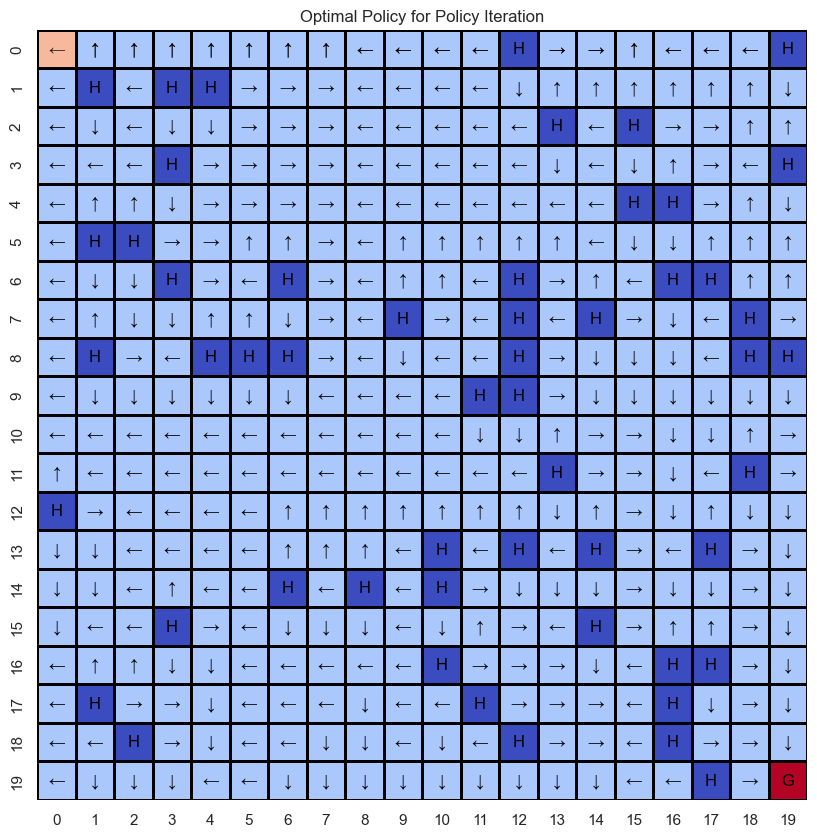

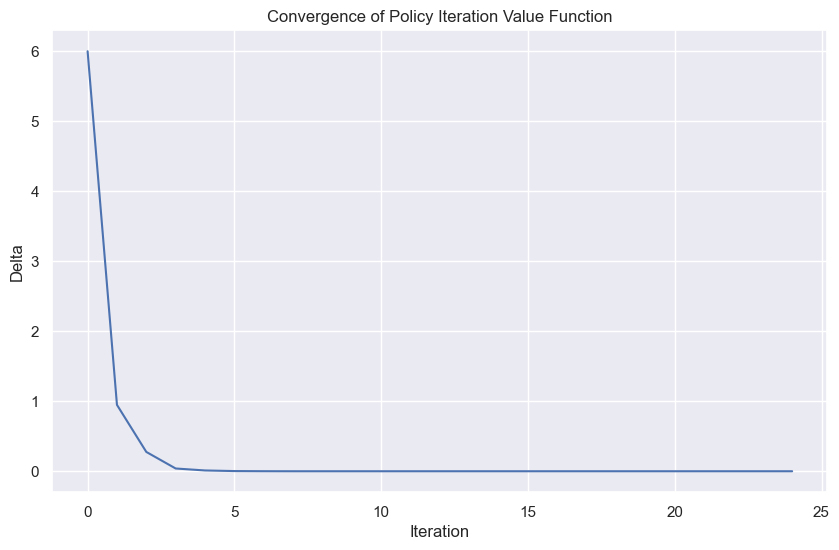

In [15]:
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from frozenlakes import MyMDPConverter, LearnerType
import numpy as np
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from hiive.mdptoolbox.mdp import PolicyIteration
from plots import find_terminal_states
from matplotlib import pyplot as plt
from newPlots import print_value_iteration_results, plot_optimal_policy_with_holes
import numpy as np

debug = False
learner_name = LearnerType.POLICY_ITERATION


env, P, R = setup_env()

# PI_learner = PolicyIteration(P, R, gamma=params.gamma, max_iter=25)


# stats = PI_learner.run()
import matplotlib.pyplot as plt
import pandas as pd

# Run Policy Iteration and collect stats
PI_learner = PolicyIteration(P, R, gamma=params.gamma, max_iter=25)
PI_learner.run()

# Initialize lists to collect stats
rewards_per_iteration = []
max_v_per_iteration = []
mean_v_per_iteration = []

# Extract stats for each iteration
for stat in PI_learner.run_stats:
    rewards_per_iteration.append(stat['Reward'])
    max_v_per_iteration.append(stat['Max V'])
    mean_v_per_iteration.append(stat['Mean V'])

# Convert lists to a pandas DataFrame for easy plotting
pi_stats = pd.DataFrame({
    'Iteration': range(1, len(rewards_per_iteration) + 1),
    'Cumulative Reward': np.cumsum(rewards_per_iteration),
    'Max V': max_v_per_iteration,
    'Mean V': mean_v_per_iteration
})

# Plot Cumulative Reward vs Iteration
plt.figure(figsize=(10, 6))
plt.plot(pi_stats['Iteration'], pi_stats['Cumulative Reward'], label='Cumulative Reward')
plt.xlabel('Iteration')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward vs Iteration for Policy Iteration')
plt.legend()
plt.show()

# Plot Max V vs Iteration
plt.figure(figsize=(10, 6))
plt.plot(pi_stats['Iteration'], pi_stats['Max V'], label='Max V-value')
plt.xlabel('Iteration')
plt.ylabel('Max V-value')
plt.title('Max V-value vs Iteration for Policy Iteration')
plt.legend()
plt.show()

# Plot Mean V vs Iteration
plt.figure(figsize=(10, 6))
plt.plot(pi_stats['Iteration'], pi_stats['Mean V'], label='Mean V-value')
plt.xlabel('Iteration')
plt.ylabel('Mean V-value')
plt.title('Mean V-value vs Iteration for Policy Iteration')
plt.legend()
plt.show()


print("max v values", pi_stats['Max V'])
# If the policy is a tuple, convert it to a NumPy array
if isinstance(PI_learner.policy, tuple):
    policy_array = np.array(PI_learner.policy)
else:
    policy_array = PI_learner.policy  # If it's already an array, just use it as is

# Now print the policy array and its shape
print("Policy array:", policy_array) if debug else None
print("Shape of policy array:", policy_array.shape) if debug else None

# Verify the values in the policy:
print("Unique actions in policy:", np.unique(policy_array)) if debug else None

# Check if all states have a valid policy (no NaNs or unexpected values):
if np.all(np.isfinite(policy_array)) and set(np.unique(policy_array)).issubset({0, 1, 2, 3}):
    print("All states have a valid policy.") if debug else None
else:
    print("There are states with an invalid policy.") if debug else None
desc = env.unwrapped.desc
plot_optimal_policy_with_holes(PI_learner.policy, desc, map_size, learner_name)

print_value_iteration_results(PI_learner, map_size, learner_name)

# plot_value_iteration_results(learner.V, learner.policy, env, map_size)
# plot_value_function(learner.V, map_size)
# plot_convergence(learner.run_stats, title='Value Iteration Convergence')


env.close()

### Plotting policy size with state space

Map size: 4
State after reset: (0, {'prob': 1})


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(


Map size: 8
State after reset: (0, {'prob': 1})
Map size: 12
State after reset: (0, {'prob': 1})
Map size: 16
State after reset: (0, {'prob': 1})
Map size: 20
State after reset: (0, {'prob': 1})


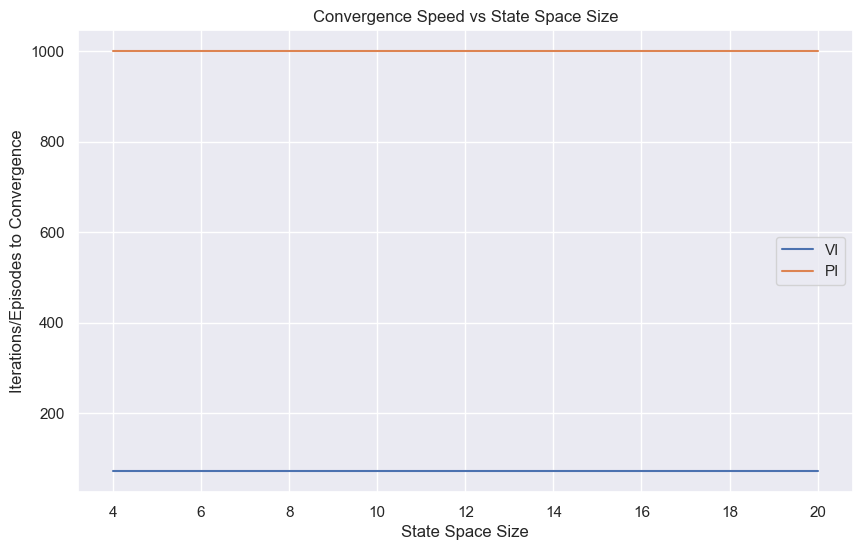

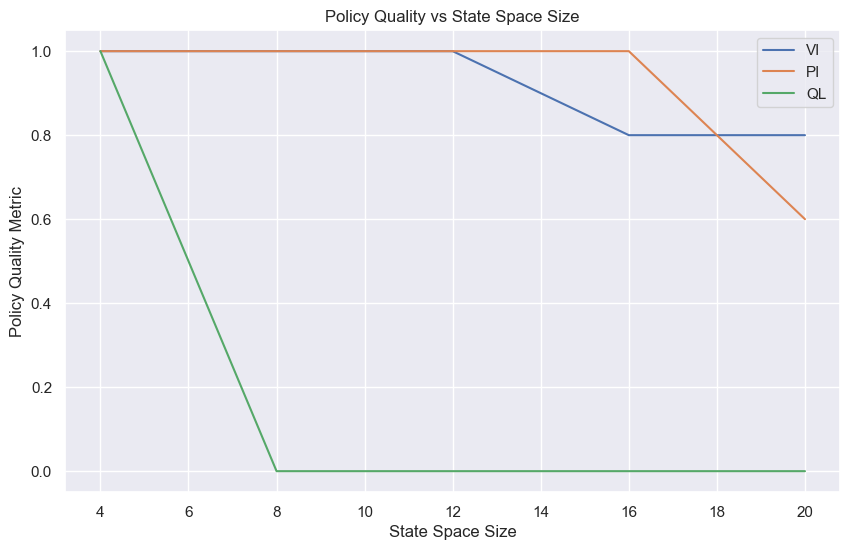

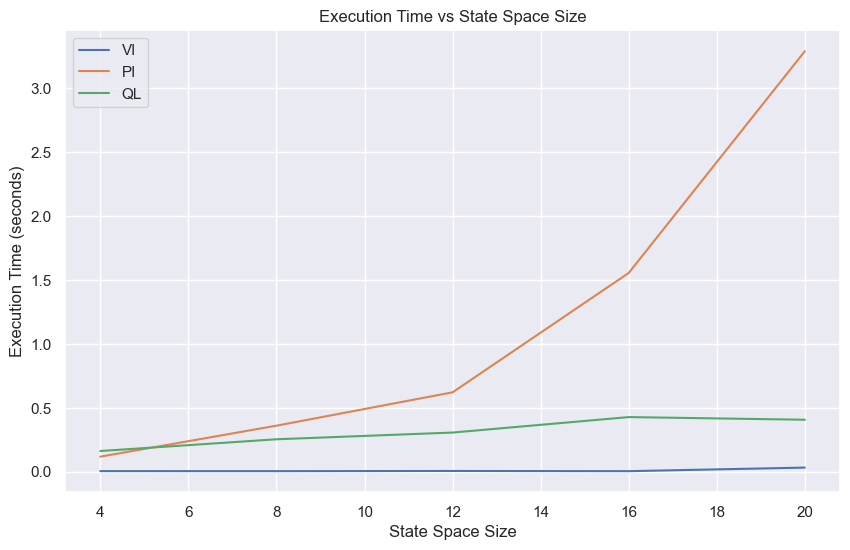

In [16]:
import matplotlib.pyplot as plt
from hiive.mdptoolbox.mdp import QLearning, PolicyIteration, ValueIteration
import time


# Modify the pos_to_state function as needed for your environment
def pos_to_state(row, col, size):
    return row * size + col

def evaluate_policy_quality(env, policy, size):
    total_reward = 0
    num_episodes = 5

    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False

        while not done:
            action = policy[state]
            next_state, reward, done, _, _ = env.step(action)  # Adjusted unpacking here
            state = next_state  # Update state for the next iteration

            total_reward += reward

    average_reward = total_reward / num_episodes
    return average_reward

map_sizes = [4, 8, 12, 16, 20]  # Example different map sizes
convergence_speeds = {'VI': [], 'PI': []}
execution_times = {'VI': [], 'PI': [], 'QL': []}
policy_qualities = {'VI': [], 'PI': [], 'QL': []}

for map_size in map_sizes:
    print("Map size:", map_size)

    env, P, R = setup_env()  # Your setup_env function, adjusted for different map_sizes
    state = env.reset()
    print("State after reset:", state)

    # Time Value Iteration
    start_time = time.time()
    vi = ValueIteration(P, R, params.gamma)
    vi.run()
    vi_time = time.time() - start_time
    execution_times['VI'].append(vi_time)

    convergence_speeds['VI'].append(vi.iter)
    policy_quality = evaluate_policy_quality(env, vi.policy, map_size)
    policy_qualities['VI'].append(policy_quality)

    # Time Policy Iteration
    start_time = time.time()
    pi = PolicyIteration(P, R, params.gamma)
    pi.run()
    pi_time = time.time() - start_time
    execution_times['PI'].append(pi_time)

    convergence_speeds['PI'].append(pi.iter)
    policy_quality = evaluate_policy_quality(env, pi.policy, map_size)
    policy_qualities['PI'].append(policy_quality)

    # Time Q-Learning
    start_time = time.time()
    ql = QLearning(P, R, gamma=0.95, alpha=0.1, epsilon=0.9, n_iter=10000)
    ql.run()
    ql_time = time.time() - start_time
    execution_times['QL'].append(ql_time)

    policy_quality = evaluate_policy_quality(env, ql.policy, map_size)
    policy_qualities['QL'].append(policy_quality)


# Set the size of each individual plot
plot_size = (10, 6)

# Plot for Convergence Speed
plt.figure(figsize=plot_size)
for algo in convergence_speeds:
    plt.plot(map_sizes, convergence_speeds[algo], label=algo)
plt.xlabel('State Space Size')
plt.ylabel('Iterations/Episodes to Convergence')
plt.title('Convergence Speed vs State Space Size')
plt.legend()
plt.show()  # Show the first plot

# Plot for Policy Quality
plt.figure(figsize=plot_size)
for algo in policy_qualities:
    plt.plot(map_sizes, policy_qualities[algo], label=algo)
plt.xlabel('State Space Size')
plt.ylabel('Policy Quality Metric')
plt.title('Policy Quality vs State Space Size')
plt.legend()
plt.show()  # Show the second plot

# Plot for Execution Time
plt.figure(figsize=plot_size)
for algo in execution_times:
    plt.plot(map_sizes, execution_times[algo], label=algo)
plt.xlabel('State Space Size')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time vs State Space Size')
plt.legend()
plt.show()  # Show the third plot



### QLearning

In [3]:
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from frozenlakes import MyMDPConverter, LearnerType
import numpy as np
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from hiive.mdptoolbox.mdp import QLearning
from plots import find_terminal_states
from matplotlib import pyplot as plt
from newPlots import print_value_iteration_results, plot_optimal_policy_with_holes
import numpy as np
import time

debug = False
learner_name = LearnerType.Q_LEARNING
env, P, R = setup_env()
plot_size = (10, 6)

def plot_stats(df_stats):
    plt.figure(figsize=plot_size)
    plt.plot(df_stats['episode'], df_stats['mean_v'], label='Mean V-value')
    plt.xlabel('Episode')
    plt.ylabel('Mean V-value')
    plt.title('Mean V-value over Episodes')
    plt.legend()
    plt.show()

    # Plotting cumulative rewards over episodes
    plt.figure(figsize=plot_size)
    plt.plot(df_stats['episode'], df_stats['cumulative_reward'], label='Cumulative Reward', color='blue')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Cumulative Reward Over Episodes')
    plt.legend()
    plt.show()

    # Plotting errors over episodes
    plt.figure(figsize=plot_size)
    plt.plot(df_stats['episode'], df_stats['error'], label='Error', color='red')
    plt.xlabel('Episode')
    plt.ylabel('Error')
    plt.title('Error Over Episodes')
    plt.legend()
    plt.show()

    plt.figure(figsize=plot_size)
    plt.plot(df_stats['episode'], df_stats['mean_q'], label='Mean Q-value')
    plt.xlabel('Episode')
    plt.ylabel('Mean Q-value')
    plt.title('Mean Q-value over Episodes')
    plt.legend()
    plt.show()

    # Calculate a simple moving average of the rewards
    window_size = 80000  # Number of episodes to include in the moving average
    cumulative_rewards = np.array(df_stats['cumulative_reward'])
    smoothed_rewards = np.convolve(cumulative_rewards, np.ones(window_size)/window_size, mode='valid')

    plt.figure(figsize=(12, 6))
    plt.plot(smoothed_rewards, label='Smoothed Cumulative Reward')
    plt.xlabel('Episode')
    plt.ylabel('Smoothed Cumulative Reward')
    plt.title('Smoothed Cumulative Reward Over Episodes')
    plt.legend()
    plt.show()



params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)
# try alpha=0.05 or 0,2
# try gamma=0.95, 0.99
# try episolin=0.9 and epsilon decay strategy using epsilon*=epsilon_decay
initial_epsilon = 0.95  # Starting value for epsilon
epsilon_decay = 0.9995  # The factor by which epsilon is multiplied each episode
minimum_epsilon = 0.05  # The minimum value that epsilon can reach
alpha = 0.1  # Learning rate
gamma = 0.95  # Discount factor
n_iter = 1250000  # Total number of episodes

stats = {
    'episode': [],
    'epsilon': [],
    'cumulative_reward': [],
    'error': [],
    'mean_v': [],
    'mean_q': []
}
env.action_space.seed(
    params.seed
)
env.reset()
# Initialize QLearning with the initial epsilon
Q_learner = QLearning(P, R, alpha=alpha, gamma=gamma, epsilon=initial_epsilon, n_iter=1)

# Manually run the learning process for n_iter episodes with epsilon decay
for episode in range(n_iter):
    # Run one episode at a time
    decayFlag = False
    decaymin = 0
    start_time = time.time()
    current_stats = Q_learner.run()
    end_time = time.time()

    cumulative_reward = sum([step['Reward'] for step in current_stats])
    print(f"Episode: {episode}, Cumulative Reward: {cumulative_reward}")
    
    stats['episode'].append(episode)
    stats['epsilon'].append(Q_learner.epsilon)
    stats['cumulative_reward'].append(sum([step['Reward'] for step in current_stats]))
    stats['error'].append(max([step['Error'] for step in current_stats]))
    # After each episode, compute the mean of the maximum Q-values for all states
    # Assume learner.Q is the Q-table with shape (number_of_states, number_of_actions)
    mean_v = np.mean(np.max(Q_learner.Q, axis=1))
    stats['mean_v'].append(mean_v)

    mean_q = np.mean(Q_learner.Q)
    stats['mean_q'].append(mean_q)

    # Update epsilon with decay, ensuring it doesn't go below the minimum value, AFTER a certin value of espisodes
    # in this case after 25% of max iters
    print("episode", episode, "n_iter", n_iter, "n_iter/4", n_iter/4)
    if episode > (n_iter/4):
        print("reducing")
        Q_learner.epsilon = max(Q_learner.epsilon * epsilon_decay, minimum_epsilon)
        if Q_learner.epsilon == minimum_epsilon and decayFlag == False:
            decayFlag = True
            decaymin = episode
    # Optionally, you can store or print the current epsilon value to monitor the decay
    print(f"Episode: {episode}, Epsilon: {Q_learner.epsilon}")
    print(f"Episode: {episode}, Mean Q-value: {mean_q}, Time: {end_time - start_time}")

df_stats = pd.DataFrame(stats)
print("decay min reached at ", decaymin)
plot_stats(df_stats)


# stats = learner.run()
print("stats\n", stats) if debug else None
# plot_policy(learner.policy, map_size)
term_states = find_terminal_states(env)

# Print the type of the policy to confirm what it is
print("Type of policy:", type(Q_learner.policy)) if debug else None

# If the policy is a tuple, convert it to a NumPy array
if isinstance(Q_learner.policy, tuple):
    policy_array = np.array(Q_learner.policy)
else:
    policy_array = Q_learner.policy  # If it's already an array, just use it as is

# Now print the policy array and its shape
print("Policy array:", policy_array) if debug else None
print("Shape of policy array:", policy_array.shape) if debug else None

# Verify the values in the policy:
print("Unique actions in policy:", np.unique(policy_array)) if debug else None

# Check if all states have a valid policy (no NaNs or unexpected values):
if np.all(np.isfinite(policy_array)) and set(np.unique(policy_array)).issubset({0, 1, 2, 3}):
    print("All states have a valid policy.") if debug else None
else:
    print("There are states with an invalid policy.") if debug else None
desc = env.unwrapped.desc
plot_optimal_policy_with_holes(Q_learner.policy, desc, map_size, learner_name)

# plot_value_iteration_results(learner.V, learner.policy, env, map_size)
# plot_value_function(learner.V, map_size)
# plot_convergence(learner.run_stats, title='Value Iteration Convergence')


env.close()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(


NameError: name 'time' is not defined

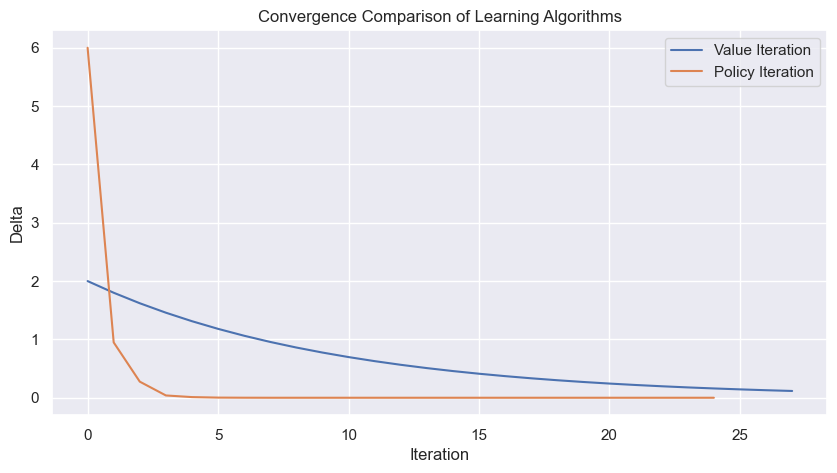

In [20]:
from newPlots import print_delta_algorithm_results

print_delta_algorithm_results([V_learner, PI_learner], map_size, ["Value Iteration", "Policy Iteration"])

## Forest MDP

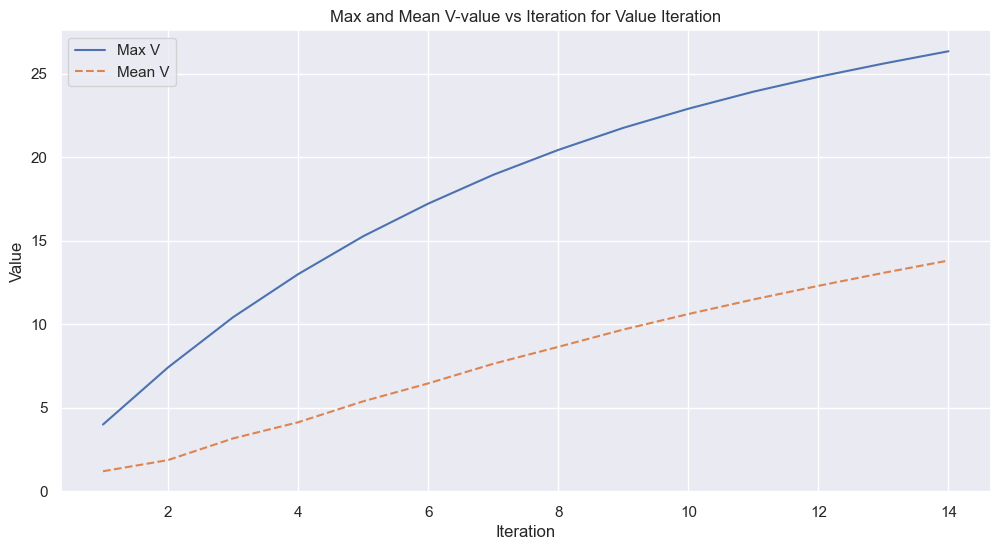

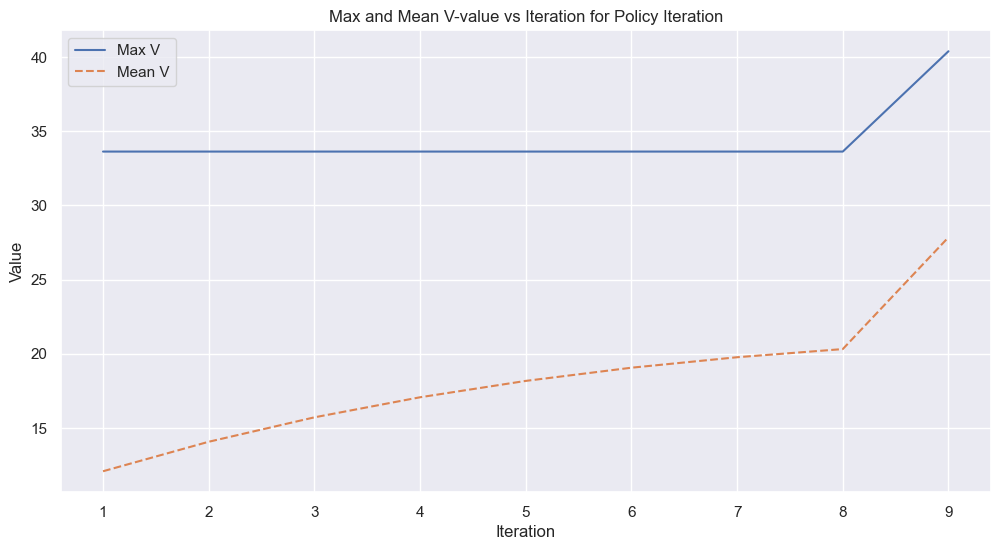

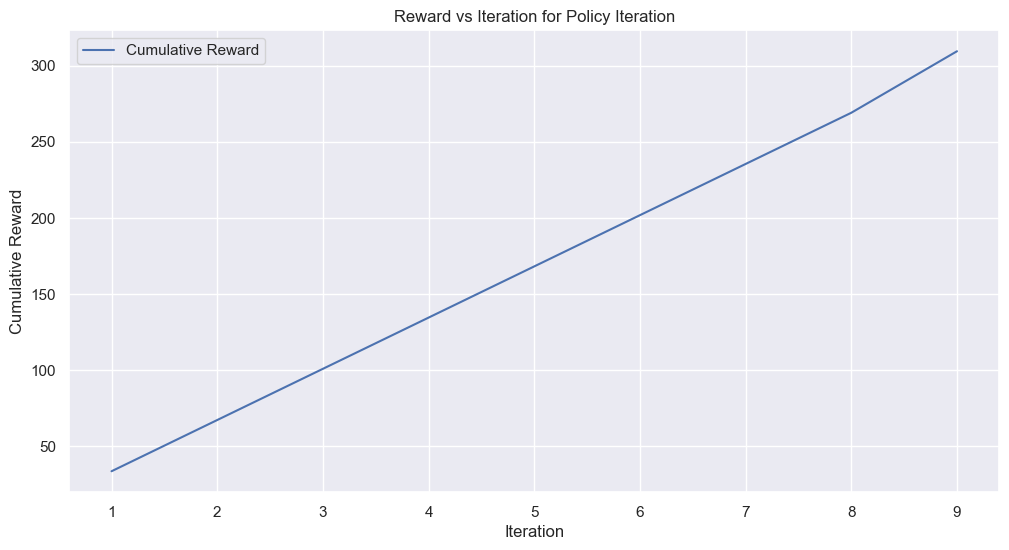

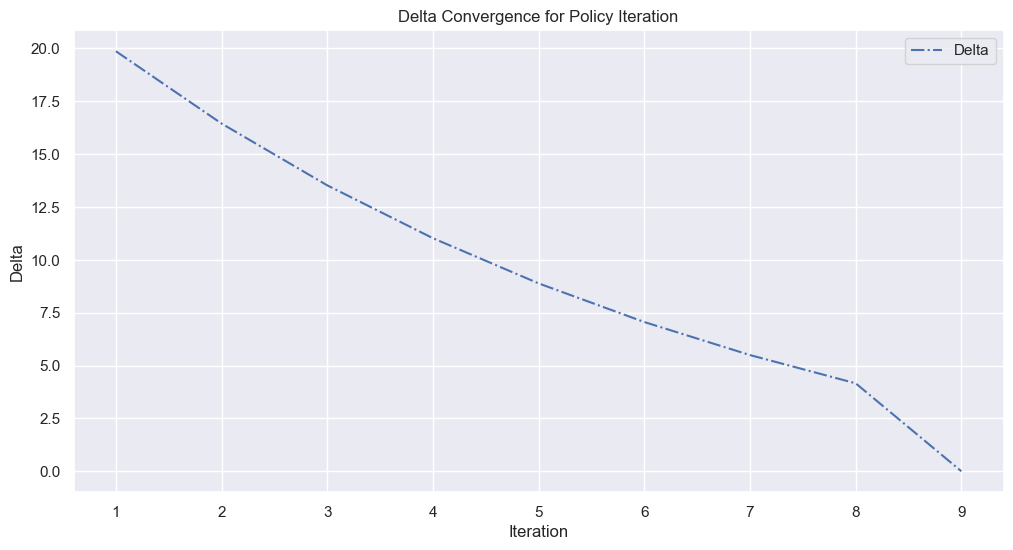

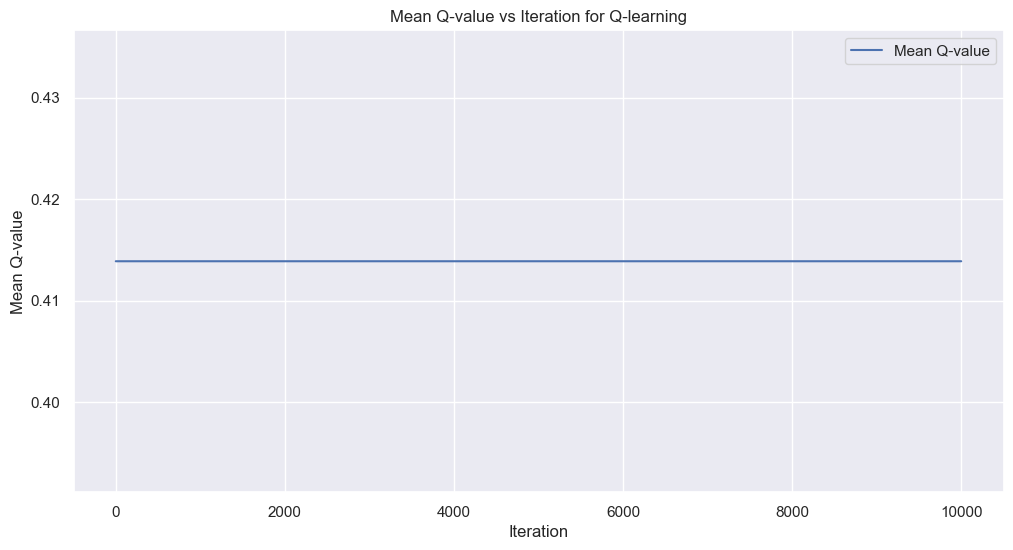

In [9]:
import mdptoolbox, mdptoolbox.example
import numpy as np
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning

import matplotlib.pyplot as plt
import numpy as np
from hiive.mdptoolbox import mdp
from hiive.mdptoolbox.example import forest

# # Set up the forest MDP problem
# P, R = forest(S=10)
# vi = mdp.ValueIteration(P, R, 0.9)
# vi.run()
# policy = np.array(vi.policy)

# Plot the policy
def plot_forest_policy(policy, learner):
    ages = np.arange(len(policy))
    actions = ['Wait' if p == 0 else 'Cut' for p in policy]
    colors = ['green' if a == 'Wait' else 'red' for a in actions]

    plt.figure(figsize=(10, 6))
    plt.bar(ages, np.ones_like(ages), color=colors)
    plt.xticks(ages, actions)
    plt.xlabel('Age of the Forest')
    plt.ylabel('Action')
    plt.title(f'Policy for Forest Management with {learner}')
    plt.show()

def plot_max_mean_v(run_stats, title):
    iterations = [s['Iteration'] for s in run_stats]
    max_v = [s['Max V'] for s in run_stats]
    mean_v = [s['Mean V'] for s in run_stats]

    plt.figure(figsize=(10, 6))
    plt.plot(iterations, max_v, label='Max V')
    plt.plot(iterations, mean_v, label='Mean V', linestyle='--')
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_reward(run_stats, title):
    iterations = [s['Iteration'] for s in run_stats]
    rewards = [s['Reward'] for s in run_stats]

    plt.figure(figsize=(10, 6))
    plt.plot(iterations, np.cumsum(rewards), label='Cumulative Reward')
    plt.xlabel('Iteration')
    plt.ylabel('Cumulative Reward')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_delta_convergence(run_stats, title):
    iterations = [s['Iteration'] for s in run_stats]
    delta = [s['Error'] for s in run_stats]

    plt.figure(figsize=(10, 6))
    plt.plot(iterations, delta, label='Delta', linestyle='-.')
    plt.xlabel('Iteration')
    plt.ylabel('Delta')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_mean_q(Q_learner, title, n_iter):
    mean_q = [np.mean(Q_learner.Q)] * n_iter

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_iter + 1), mean_q, label='Mean Q-value')
    plt.xlabel('Iteration')
    plt.ylabel('Mean Q-value')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_state_space_vs_time(state_spaces, times, title):
    plt.figure(figsize=(10, 6))
    plt.plot(state_spaces, times, label='Wall Clock Time', marker='o')
    plt.xlabel('State Space Size')
    plt.ylabel('Time (seconds)')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_learning_rate_vs_performance(learning_rates, performances, title):
    plt.figure(figsize=(10, 6))
    plt.plot(learning_rates, performances, label='Performance', marker='x')
    plt.xlabel('Learning Rate')
    plt.ylabel('Performance')
    plt.title(title)
    plt.legend()
    plt.show()

size = 10
P, R = mdptoolbox.example.forest(S=size, r1=4, r2=2, p=0.1)

for learnerType in LearnerType:
    if learnerType == LearnerType.VALUE_ITERATION:
        vi_learner = ValueIteration(P, R, 0.95)
        vi_learner.run()
        # print_value_iteration_results(vi_learner, size, learnerType)

    elif learnerType == LearnerType.POLICY_ITERATION:
        pi_learner = PolicyIteration(P, R, 0.95)
        pi_learner.run()
        # print_value_iteration_results(pi_learner, size, learnerType)

    else:
        q_learner = QLearning(P, R, gamma=0.95, alpha=0.1, n_iter=10000)
        q_learner.run()

    # print("Learner Policy:", learner.policy)
    # policy = np.array(learner.policy)

    # plot_forest_policy(policy, learnerType)



# Example usage after running the learners:
# VI_learner = ValueIteration(P, R, gamma=0.95)
# VI_learner.run()

# PI_learner = PolicyIteration(P, R, gamma=0.95)
# PI_learner.run()

# QL_learner = QLearning(P, R, alpha=0.1, gamma=0.95, n_iter=10000)
# QL_learner.run()

#PI
plot_max_mean_v(pi_learner.run_stats, 'Max and Mean V-value vs Iteration for Policy Iteration')
plot_reward(pi_learner.run_stats, 'Reward vs Iteration for Policy Iteration')
plot_delta_convergence(pi_learner.run_stats, 'Delta Convergence for Policy Iteration')

#VI
plot_max_mean_v(vi_learner.run_stats, 'Max and Mean V-value vs Iteration for Value Iteration')
plot_reward(vi_learner.run_stats, 'Reward vs Iteration for Value Iteration')
plot_delta_convergence(vi_learner.run_stats, 'Delta Convergence for Value Iteration')

#Qlearn
plot_mean_q(q_learner, 'Mean Q-value vs Iteration for Q-learning', 10000)

# For state space vs time and learning rate vs performance, you will need to collect the relevant data.

